In [8]:
library(KEGGREST)
#library(igraph)
library(ggplot2)
#library(ReactomePA)
library(biomaRt)
library(clusterProfiler)
library(org.Hs.eg.db)
library(limma)
library(dplyr)
library(tidyr)
library(babelgene)
library(DOSE)
library(org.Mm.eg.db)
library(ggVennDiagram)

ERROR: Error in library(clusterProfiler): there is no package called ‘clusterProfiler’


In [34]:
#install.packages('~/R/library/KEGGREST_1.44.1.tar.gz', repos=NULL, type='source', force=TRUE)
#install.packages("tidyverse")
#install.packages('~/R/library/bcurl_5.2.3.tar.gz', repos=NULL, type='source', force=TRUE)
#BiocManager::install(version = "3.19", force=TRUE, ask=FALSE)
#BiocManager::install('biomaRt')
#rm -rd /home/eshipulina/miniconda3/envs/DEXSeq/lib/R/library/00LOCK-GOSemSim
#BiocManager::install('GOSemSim')
#BiocManager::install('DOSE')
#BiocManager::install('enrichplot')
#BiocManager::install('clusterProfiler')
#BiocManager::install('org.Hs.eg.db')
# BiocManager::install('limma')
# install.packages('dplyr')
# install.packages('tidyr')
# install.packages('babelgene')
# BiocManager::install('org.Mm.eg.db')

In [16]:
#результаты, которые выдели тулы. rmats был получен при помощи maser
#rmats <- read.csv('../splicing_rMATS/rmats_top_events_adj_wo_pairedstats_startend.csv')
majiq <- read.csv('../splicing_MAJIQ/output/deltapsi_repeat/Senexin-DMSO.deltapsi.tsv', sep='\t')
#dexseq <- read.csv('../splicing_DEXSeq/dxr2.csv')
#dexseq <- dexseq[dexseq$padj < 0.1, ] %>% drop_na(padj)

In [17]:
# Step 1: Split the columns with semicolon-separated values into lists
majiq$Senexin_mean_psi <- strsplit(majiq$Senexin_mean_psi, ";")
majiq$DMSO_mean_psi <- strsplit(majiq$DMSO_mean_psi, ";")
majiq$probability_non_changing <- strsplit(majiq$probability_non_changing, ";")
majiq$probability_changing <- strsplit(majiq$probability_changing, ";")

majiq$junctions_coords <- strsplit(majiq$junctions_coords, ";")

# Step 2: Use unnest to explode lists into new rows
majiq <- majiq %>%
  unnest(c(Senexin_mean_psi, DMSO_mean_psi, probability_non_changing, 
          junctions_coords, probability_changing))

majiq <- as.data.frame(majiq)

# Convert columns to numeric
majiq$Senexin_mean_psi <- as.numeric(majiq$Senexin_mean_psi)
majiq$DMSO_mean_psi <- as.numeric(majiq$DMSO_mean_psi)
majiq$probability_non_changing <- as.numeric(majiq$probability_non_changing)
majiq$probability_changing <- as.numeric(majiq$probability_changing)

# Split 'junctions_coords' into 'start' and 'end'
majiq$junctions_coords <- strsplit(majiq$junctions_coords, "-")
majiq$start <- as.integer(sapply(majiq$junctions_coords, `[`, 1))
majiq$end <- as.integer(sapply(majiq$junctions_coords, `[`, 2))

# Filter the dataframe based on conditions
majiq <- majiq[abs(majiq$Senexin_mean_psi - majiq$DMSO_mean_psi) > 0.1, ]
majiq <- majiq[majiq$probability_non_changing < 0.05, ]

majiq <- as.data.frame(majiq)
length(unique(majiq$gene_id))

[1] 410

In [38]:
# Select the Ensembl BioMart dataset for mouse genes
ensembl <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")

# переконвертировать ensembl_gene_id в entrezgene_id для генов, для которых показаны различия в сплайсинге для всех трех тулов
rmats_entrez <- getBM(attributes = c("ensembl_gene_id", "entrezgene_id"),
                filters = "ensembl_gene_id",
                values = rmats$GeneID,
                mart = ensembl)

majiq_entrez <- getBM(attributes = c("ensembl_gene_id", "entrezgene_id"),
                filters = "ensembl_gene_id",
                values = majiq$gene_id,
                mart = ensembl)

dexseq_entrez <- getBM(attributes = c("ensembl_gene_id", "entrezgene_id"),
                filters = "ensembl_gene_id",
                values = dexseq$groupID,
                mart = ensembl)

In [39]:
colnames(rmats_entrez) <- c('GeneID', 'entrezgene_id')
colnames(majiq_entrez) <- c('gene_id', 'entrezgene_id')
colnames(dexseq_entrez) <- c('groupID', 'entrezgene_id')

rmats <- merge(rmats, rmats_entrez, by = "GeneID")
majiq <- merge(majiq_entrez, majiq, by = "gene_id")
dexseq <- merge(dexseq_entrez, dexseq, by = "groupID")

In [ ]:
#write.csv(rmats,"rmats_with_all_IDs.csv", row.names = FALSE)
#write.csv(majiq,"majiq_with_all_IDs.csv", row.names = FALSE)
#write.csv(dexseq,"dexseq_with_all_IDs.csv", row.names = FALSE)

In [21]:
#загружаем файлы, где есть айди и ensemble, и entrez
rmats <- read.csv("rmats_with_all_IDs.csv")
majiq <- read.csv("majiq_with_all_IDs.csv")
dexseq <- read.csv("dexseq_with_all_IDs.csv")
# Step 1: Split the columns with semicolon-separated values into lists
majiq$Senexin_mean_psi <- strsplit(majiq$Senexin_mean_psi, ";")
majiq$DMSO_mean_psi <- strsplit(majiq$DMSO_mean_psi, ";")
majiq$probability_non_changing <- strsplit(majiq$probability_non_changing, ";")
majiq$probability_changing <- strsplit(majiq$probability_changing, ";")

majiq$junctions_coords <- strsplit(majiq$junctions_coords, ";")

# Step 2: Use unnest to explode lists into new rows
majiq <- majiq %>%
  unnest(c(Senexin_mean_psi, DMSO_mean_psi, probability_non_changing, 
          junctions_coords, probability_changing))

majiq <- as.data.frame(majiq)

# Convert columns to numeric
majiq$Senexin_mean_psi <- as.numeric(majiq$Senexin_mean_psi)
majiq$DMSO_mean_psi <- as.numeric(majiq$DMSO_mean_psi)
majiq$probability_non_changing <- as.numeric(majiq$probability_non_changing)
majiq$probability_changing <- as.numeric(majiq$probability_changing)

# Split 'junctions_coords' into 'start' and 'end'
majiq$junctions_coords <- strsplit(majiq$junctions_coords, "-")
majiq$start <- as.integer(sapply(majiq$junctions_coords, `[`, 1))
majiq$end <- as.integer(sapply(majiq$junctions_coords, `[`, 2))

# Filter the dataframe based on conditions
majiq <- majiq[abs(majiq$Senexin_mean_psi - majiq$DMSO_mean_psi) > 0.1, ]
majiq <- majiq[majiq$probability_non_changing < 0.05, ]

majiq <- as.data.frame(majiq)
length(unique(majiq$gene_id))

[1] 410

In [30]:
unique(majiq[c('gene_id', 'start', 'end')])

,gene_id,start,end
,<chr>,<int>,<int>
821,ENSMUSG00000000296,31208965,31214181
3698,ENSMUSG00000001036,61435154,61436976
3699,ENSMUSG00000001036,61426209,61436976
5734,ENSMUSG00000001517,128348975,128349497
5735,ENSMUSG00000001517,128348048,128348931
6269,ENSMUSG00000001786,85858008,85860280
6272,ENSMUSG00000001786,85858194,85860432
6341,ENSMUSG00000001829,101436942,101442609
6342,ENSMUSG00000001829,101439376,101442608


In [32]:
write.csv(unique(majiq[c('gene_id', 'start', 'end')]),"majiq_with_all_IDs_nease.csv", row.names = FALSE)

In [ ]:
#KEGG ANALYSIS

In [3]:
#загрузили все пути из kegg
all_pathways <- getGeneKEGGLinks(species="mmu")

# Group by pathway_id and concatenate gene_id into a single string for each pathway
df_grouped <- all_pathways %>%
  group_by(PathwayID) %>%
  summarise(GeneID = paste(GeneID, collapse = ", "))
#теперь мы имеем таблицу, где каждому пути соответствует n генов в строчке

Reading KEGG annotation online: "https://rest.kegg.jp/link/mmu/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/mmu"...



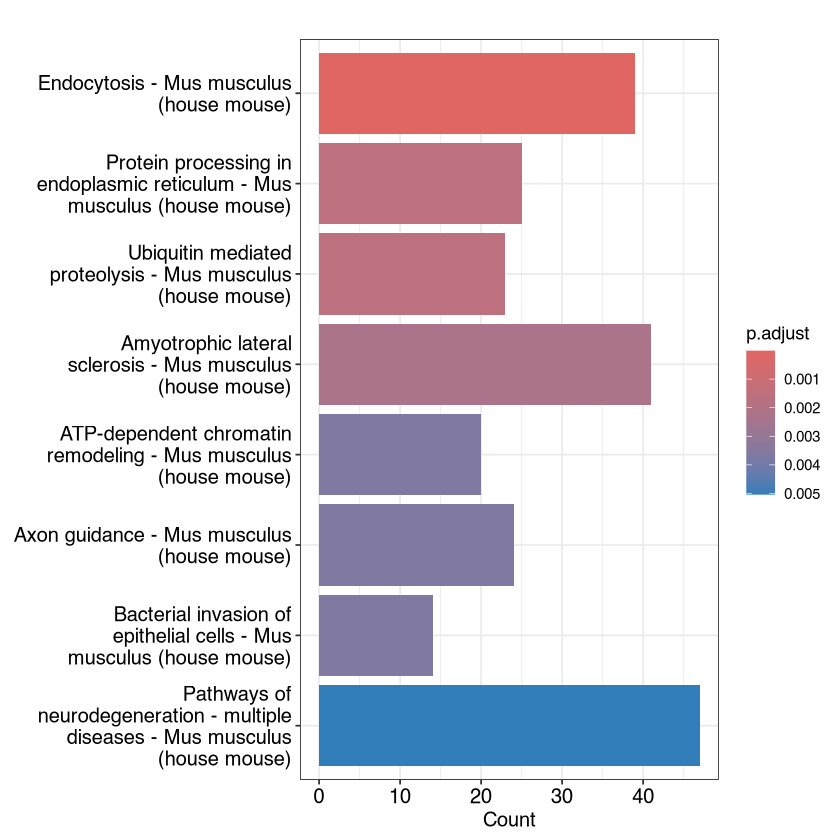

In [4]:
#for DEXSeq results

cdk_8_19 <- c('264064', '78334')
#entrez IDs for mouse

gene_list <- c(cdk_8_19, dexseq$entrezgene_id)

# KEGG enrichment analysis
kegg_enrichment <- enrichKEGG(gene = gene_list,
                              organism = 'mmu',
                              pvalueCutoff = 0.05)

pathways <- data.frame (
  PathwayID = kegg_enrichment$ID,
  Description = kegg_enrichment$Description,
  p.adjust = kegg_enrichment$p.adjust
)
#тут хранятся только enriched пути для наших образцов, dexseq

pathways <- merge(pathways, df_grouped, by = "PathwayID")
#тут хранятся наши enriched пути с перечисленными для них генами
barplot(kegg_enrichment)

In [5]:
kegg_df <- as.data.frame(kegg_enrichment)

# Create a table with two columns: KEGG pathway name and gene IDs
dexseq_kegg_gene_table <- kegg_df %>%
  select(Description, geneID) %>%  # Select the pathway name and gene IDs
  rename(Category = Description, GeneIDs = geneID)

# Optionally, you can also separate the gene IDs into a list for each pathway
dexseq_kegg_gene_table$GeneIDs <- strsplit(dexseq_kegg_gene_table$GeneIDs, "/")

In [ ]:
cdk_enrich <- pathways[grepl("78334", pathways$GeneID), ]
#find rows where IDs of CDK
cdk_enrich

cdk_enrich <- pathways[grepl("264064", pathways$GeneID), ]
#find rows where IDs of CDK
cdk_enrich

#результат: в enriched pathways отсутствуют CDKs

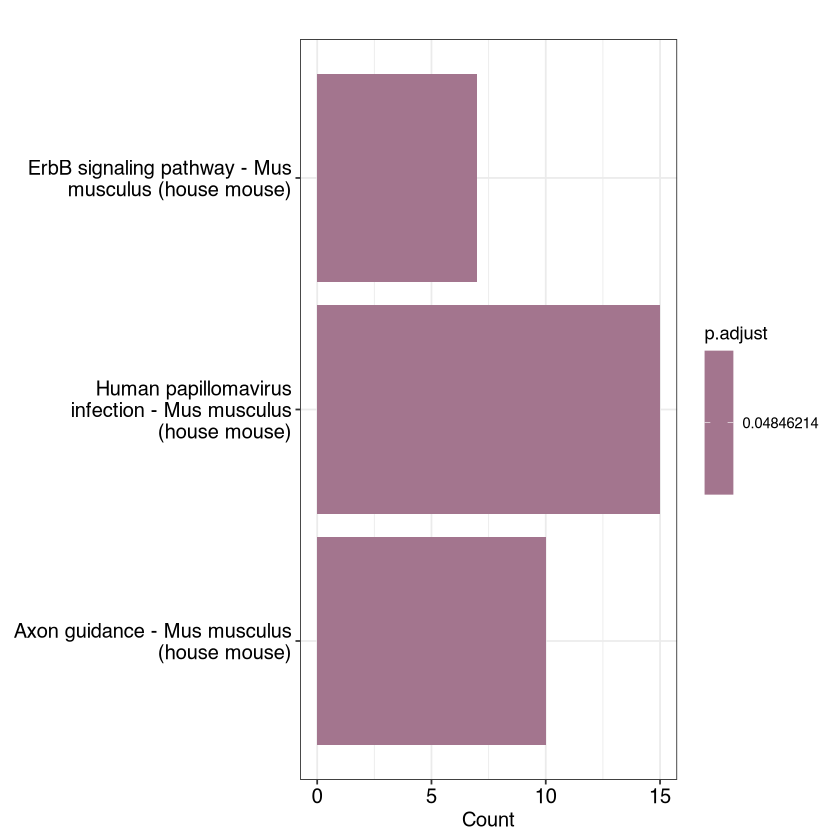

In [6]:
#for MAJIQ results
kegg_enrichment <- enrichKEGG(gene = majiq$entrezgene_id,
                              organism = 'mmu',
                              pvalueCutoff = 0.05)

pathways <- data.frame (
  PathwayID = kegg_enrichment$ID,
  Description = kegg_enrichment$Description,
  p.adjust = kegg_enrichment$p.adjust
)
pathways <- merge(pathways, df_grouped, by = "PathwayID")
#тут хранятся enriched пути с перечисленными для них генами для majiq

barplot(kegg_enrichment)

In [7]:
kegg_df <- as.data.frame(kegg_enrichment)

# Create a table with two columns: KEGG pathway name and gene IDs
majiq_kegg_gene_table <- kegg_df %>%
  select(Description, geneID) %>%  # Select the pathway name and gene IDs
  rename(Category = Description, GeneIDs = geneID)

# Optionally, you can also separate the gene IDs into a list for each pathway
majiq_kegg_gene_table$GeneIDs <- strsplit(majiq_kegg_gene_table$GeneIDs, "/")

In [19]:
cdk_enrich <- pathways[grepl("78334", pathways$GeneID), ]
#find rows where IDs of CDK
cdk_enrich

cdk_enrich <- pathways[grepl("264064", pathways$GeneID), ]
#find rows where IDs of CDK
cdk_enrich

#нет путей, в которых фигурируют CDKs

PathwayID,Description,p.adjust,GeneID
<chr>,<chr>,<dbl>,<chr>


PathwayID,Description,p.adjust,GeneID
<chr>,<chr>,<dbl>,<chr>


In [ ]:
# majiq_kegg_gene_table <- majiq_kegg_gene_table %>%
#   unnest(GeneIDs)
# dexseq_kegg_gene_table <- dexseq_kegg_gene_table %>%
#   unnest(GeneIDs)

# write.csv(majiq_kegg_gene_table,"majiq_kegg_gene_table.csv", row.names = FALSE)
# write.csv(dexseq_kegg_gene_table,"dexseq_kegg_gene_table.csv", row.names = FALSE)

#Для дальнейшего вытаскивания отсюда названий генов

In [20]:
#for rMATS results
kegg_enrichment <- enrichKEGG(gene = rmats$entrezgene_id,
                              organism = 'mmu',
                              pvalueCutoff = 0.05)

pathways <- data.frame (
  PathwayID = kegg_enrichment$ID,
  Description = kegg_enrichment$Description,
  p.adjust = kegg_enrichment$p.adjust
)
pathways <- merge(pathways, df_grouped, by = "PathwayID")
#тут хранятся enriched пути с перечисленными для них генами для rmats, но таких нет

In [ ]:
#энричмент для генов в пересечении между тулами

In [29]:
rmats_dexseq <- intersect(rmats$entrezgene_id, dexseq$entrezgene_id)
majiq_dexseq <- intersect(majiq$entrezgene_id, dexseq$entrezgene_id)

rmats_dexseq <- rmats_dexseq[!is.na(rmats_dexseq)]
majiq_dexseq <- majiq_dexseq[!is.na(majiq_dexseq)]

In [32]:
#For rmats_dexseq intersection
kegg_enrichment <- enrichKEGG(gene = rmats_dexseq,
                              organism = 'mmu',
                              pvalueCutoff = 0.05)

pathways <- data.frame (
  PathwayID = kegg_enrichment$ID,
  Description = kegg_enrichment$Description,
  p.adjust = kegg_enrichment$p.adjust
)
#тут хранятся только enriched пути для наших образцов


pathways <- merge(pathways, df_grouped, by = "PathwayID")
#тут хранятся enriched пути с перечисленными для них генами. Но таких не существует.

In [34]:
#For majiq_dexseq intersection
kegg_enrichment <- enrichKEGG(gene = majiq_dexseq,
                              organism = 'mmu',
                              pvalueCutoff = 0.05)

pathways <- data.frame (
  PathwayID = kegg_enrichment$ID,
  Description = kegg_enrichment$Description,
  p.adjust = kegg_enrichment$p.adjust
)
#тут хранятся только enriched пути для наших образцов


pathways <- merge(pathways, df_grouped, by = "PathwayID")
#тут хранятся enriched пути с перечисленными для них генами. Но таких не существует.

In [ ]:
#DISEASE ONTOLOGY

In [109]:
rmats_ortho <- orthologs(rmats$GeneID, 'Mus musculus', human = FALSE, min_support = 3, top = TRUE)
majiq_ortho <- orthologs(majiq$gene_id, 'Mus musculus', human = FALSE, min_support = 3, top = TRUE)
dexseq_ortho <- orthologs(dexseq$groupID, 'Mus musculus', human = FALSE, min_support = 3, top = TRUE)

In [110]:
rmats_enr <- enrichDO(rmats_ortho$human_entrez)
majiq_enr <- enrichDO(majiq_ortho$human_entrez)
dexseq_enr <- enrichDO(dexseq_ortho$human_entrez)

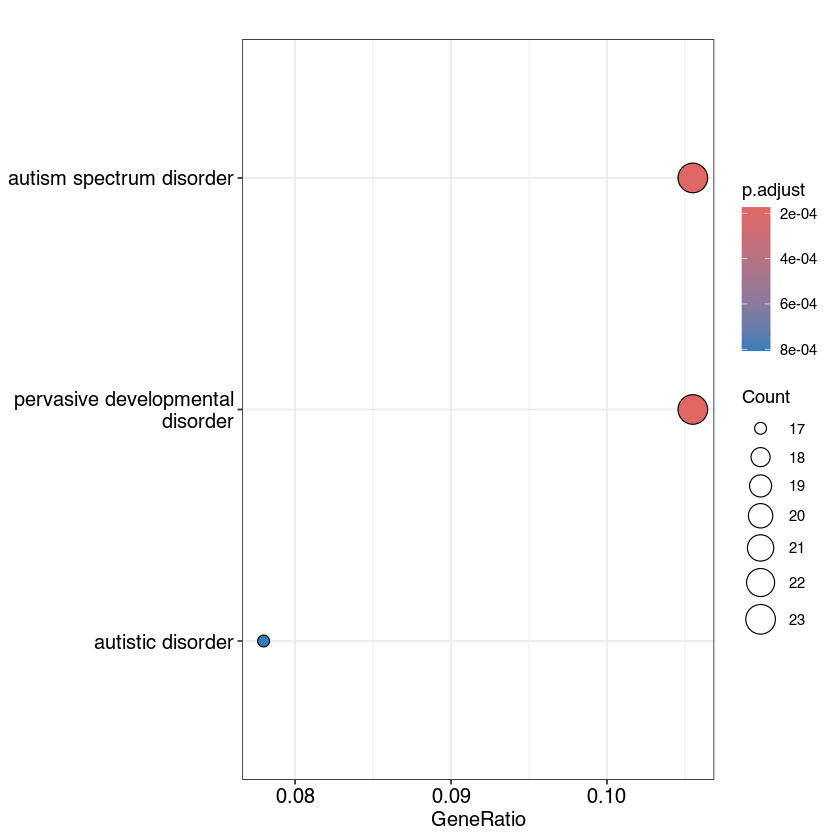

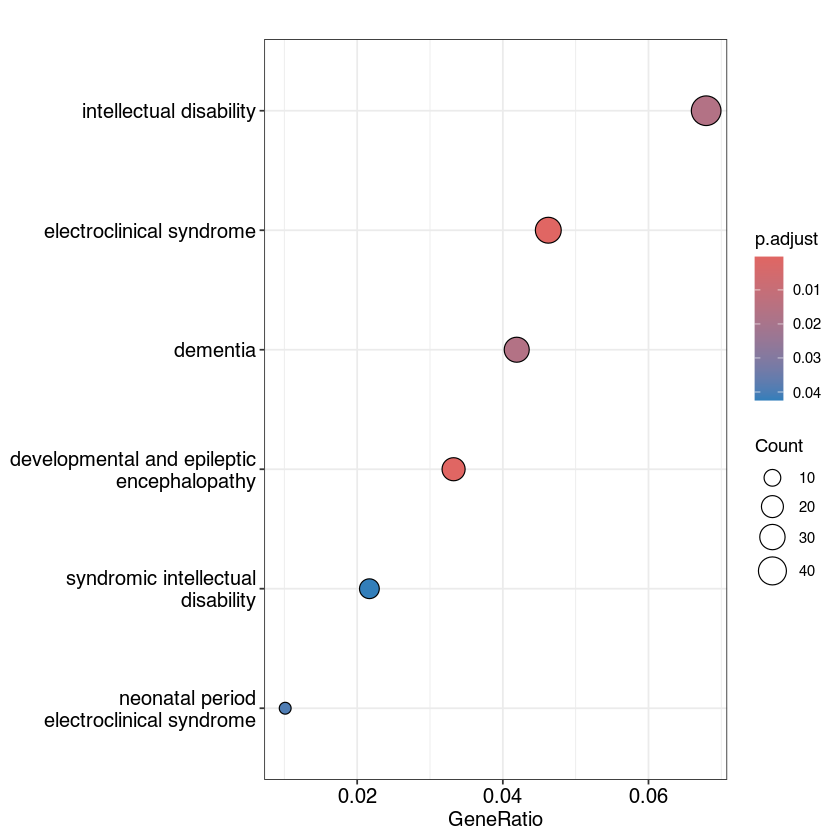

In [111]:
#dotplot(rmats_enr) doesn't exist
dotplot(majiq_enr, showCategory=10)
dotplot(dexseq_enr, showCategory=10)

In [113]:
majiq_enr_results <- majiq_enr@result
majiq_genes_pathways_DO <- majiq_enr_results %>%
  select(Description, geneID) %>%      # Select the GO term description and geneID columns
  separate_rows(geneID, sep = "/")  

In [115]:
dexseq_enr_results <- dexseq_enr@result
dexseq_genes_pathways_DO <- dexseq_enr_results %>%
  select(Description, geneID) %>%      # Select the GO term description and geneID columns
  separate_rows(geneID, sep = "/")  

In [119]:
write.csv(majiq_genes_pathways_DO,"majiq_genes_pathways_DO.csv", row.names = FALSE)
write.csv(dexseq_genes_pathways_DO,"dexseq_genes_pathways_DO.csv", row.names = FALSE)

In [ ]:
#GENE ONTOLOGY

In [49]:
# rmats_ego <- enrichGO(rmats$GeneID, OrgDb = org.Mm.eg.db, keyType = "ENSEMBL")
# barplot(rmats_ego)
#слишком мало генов

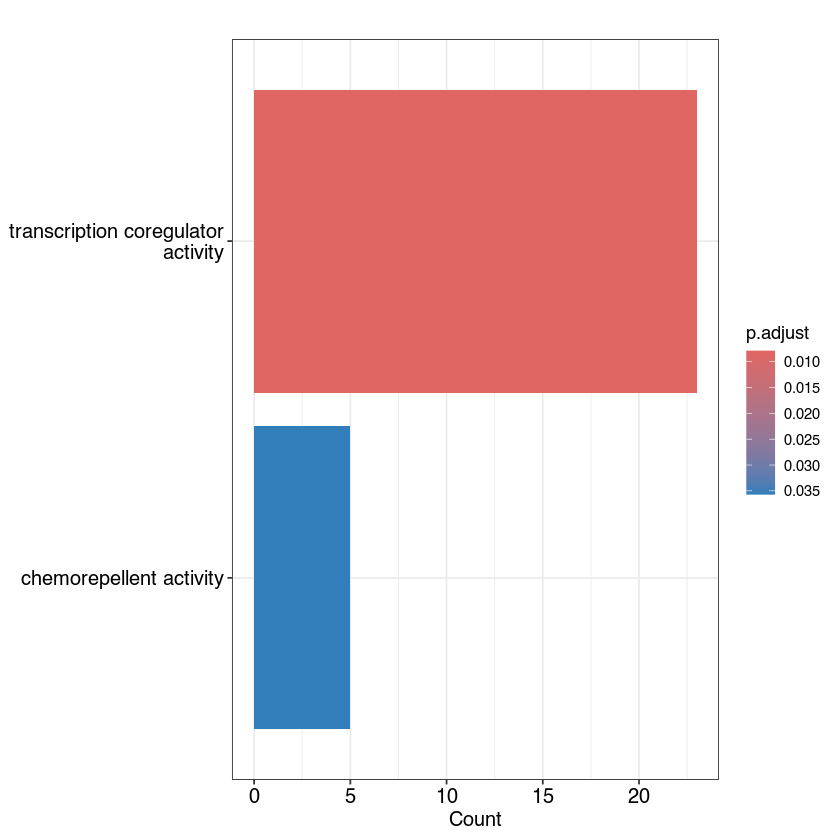

In [7]:
majiq_ego <- enrichGO(majiq$gene_id, OrgDb = org.Mm.eg.db, keyType = "ENSEMBL")
barplot(majiq_ego)

In [105]:
majiq_ego_results <- majiq_ego@result
majiq_genes_pathways <- majiq_ego_results %>%
  select(Description, geneID) %>%      # Select the GO term description and geneID columns
  separate_rows(geneID, sep = "/")  

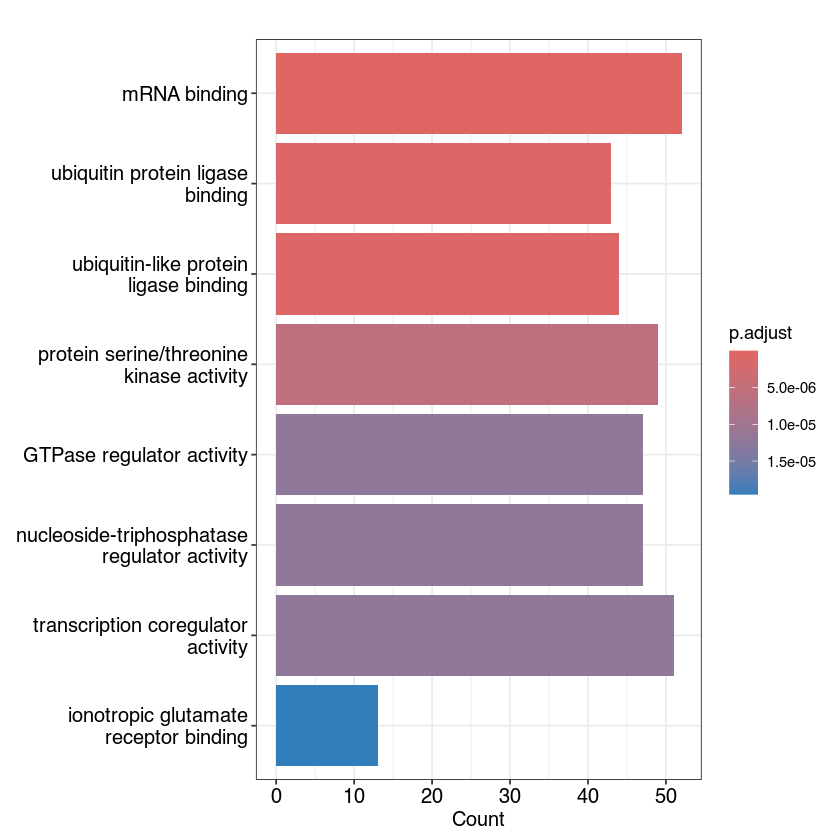

In [106]:
dexseq_ego <- enrichGO(dexseq$groupID, OrgDb = org.Mm.eg.db, keyType = "ENSEMBL")
barplot(dexseq_ego)

In [107]:
dexseq_ego_results <- dexseq_ego@result
dexseq_genes_pathways <- dexseq_ego_results %>%
  select(Description, geneID) %>%      # Select the GO term description and geneID columns
  separate_rows(geneID, sep = "/")  

In [121]:
write.csv(majiq_genes_pathways,"majiq_genes_pathways.csv", row.names = FALSE)
write.csv(dexseq_genes_pathways,"dexseq_genes_pathways.csv", row.names = FALSE)

In [ ]:
#FOR PRESENTATION

In [3]:
# Select the Ensembl BioMart dataset for mouse genes
ensembl <- useMart("ensembl", dataset = "mmusculus_gene_ensembl")
#Как-то выдал ошибку, поэтому использовала то, что ниже

In [5]:
#ensembl <- useEnsembl("ensembl", dataset = "mmusculus_gene_ensembl", mirror = "www")
#Как-то выдал ошибку, поэтому использовала то, что выше

In [4]:
# переконвертировать ensembl_gene_id в entrezgene_id для генов, для которых показаны различия в сплайсинге для всех трех тулов
rmats_symbol <- getBM(attributes = c("ensembl_gene_id", "external_gene_name"),
                filters = "ensembl_gene_id",
                values = rmats$GeneID,
                mart = ensembl)

majiq_symbol <- getBM(attributes = c("ensembl_gene_id", "external_gene_name"),
                filters = "ensembl_gene_id",
                values = majiq$gene_id,
                mart = ensembl)

dexseq_symbol <- getBM(attributes = c("ensembl_gene_id", "external_gene_name"),
                filters = "ensembl_gene_id",
                values = dexseq$groupID,
                mart = ensembl)

In [5]:
colnames(rmats_symbol) <- c('GeneID', 'gene_name')
colnames(majiq_symbol) <- c('gene_id', 'gene_name')
colnames(dexseq_symbol) <- c('groupID', 'gene_name')

In [6]:
rmats <- merge(rmats, rmats_symbol, by = "GeneID")
majiq <- merge(majiq, majiq_symbol, by = "gene_id")
dexseq <- merge(dexseq, dexseq_symbol, by = "groupID")

In [ ]:
#ниже код для получения вообще всех генов, сортированных

In [58]:
#сортировка по мере увеличения pval или probability_non_changing
rmats$PValue <- as.numeric(rmats$PValue)
rmats <- rmats[order(rmats$PValue),]

majiq$probability_non_changing <- as.numeric(majiq$probability_non_changing)
majiq <- majiq[order(majiq$probability_non_changing), ]

dexseq$padj <- as.numeric(dexseq$padj)
dexseq <- dexseq[order(dexseq$padj),]

In [66]:
length(unique(rmats$gene_name))
length(unique(majiq$gene_name))
length(unique(dexseq$gene_name))

[1] 111

[1] 408

[1] 1107

In [108]:
# paste0(unique(rmats$gene_name), collapse=", ")
# paste0(unique(majiq$gene_name), collapse=", ")
# paste0(unique(dexseq$gene_name), collapse=", ")

In [ ]:
#ниже код для получения генов по категориям KEGG, DO, GO

In [7]:
#Отсюда вытаскивать названия генов для каждого из путей
#KEGG
majiq_kegg_gene_table <- read.csv("majiq_kegg_gene_table.csv")
dexseq_kegg_gene_table <- read.csv("dexseq_kegg_gene_table.csv")

colnames(majiq_kegg_gene_table) <- c('pathway', 'entrezgene_id')
colnames(dexseq_kegg_gene_table) <- c('pathway', 'entrezgene_id')

#DO
majiq_genes_pathways_DO <- read.csv('majiq_genes_pathways_DO.csv')
dexseq_genes_pathways_DO <- read.csv('dexseq_genes_pathways_DO.csv')

colnames(majiq_genes_pathways_DO) <- c('pathway', 'human_entrezgene_id')
colnames(dexseq_genes_pathways_DO) <- c('pathway', 'human_entrezgene_id')

#GO
majiq_genes_pathways <- read.csv('majiq_genes_pathways.csv')
dexseq_genes_pathways <- read.csv('dexseq_genes_pathways.csv')

colnames(majiq_genes_pathways) <- c('pathway', 'gene_id')
colnames(dexseq_genes_pathways) <- c('pathway', 'groupID')

In [8]:
majiq_kegg_result_for_pres <- majiq_kegg_gene_table %>%
    left_join(majiq[c('gene_name', 'entrezgene_id')], by = "entrezgene_id")
majiq_kegg_result_for_pres <- unique(majiq_kegg_result_for_pres)

dexseq_kegg_result_for_pres <- dexseq_kegg_gene_table %>%
    left_join(dexseq[c('gene_name', 'entrezgene_id')], by = "entrezgene_id")
dexseq_kegg_result_for_pres <- unique(dexseq_kegg_result_for_pres)


majiq_DO_ortho <- orthologs(majiq_genes_pathways_DO$human_entrezgene_id, 'Mus musculus', human = TRUE, min_support = 3, top = TRUE)[c('symbol', 'entrez', 'human_entrez')]
colnames(majiq_DO_ortho) <- c('gene_name', 'entrezgene_id', 'human_entrezgene_id')
majiq_do_result_for_pres <- majiq_genes_pathways_DO %>%
    left_join(majiq_DO_ortho, by = "human_entrezgene_id")

dexseq_DO_ortho <- orthologs(dexseq_genes_pathways_DO$human_entrezgene_id, 'Mus musculus', human = TRUE, min_support = 3, top = TRUE)[c('symbol', 'entrez', 'human_entrez')]
colnames(dexseq_DO_ortho) <- c('gene_name', 'entrezgene_id', 'human_entrezgene_id')
dexseq_do_result_for_pres <- dexseq_genes_pathways_DO %>%
    left_join(dexseq_DO_ortho, by = "human_entrezgene_id")


majiq_go_result_for_pres <- majiq_genes_pathways %>%
    left_join(majiq[c('gene_name', 'gene_id')], by = "gene_id")
majiq_go_result_for_pres <- unique(majiq_go_result_for_pres)

dexseq_go_result_for_pres <- dexseq_genes_pathways %>%
    left_join(dexseq[c('gene_name', 'groupID')], by = "groupID")
dexseq_go_result_for_pres <- unique(dexseq_go_result_for_pres)

Warning message in left_join(., majiq[c("gene_name", "entrezgene_id")], by = "entrezgene_id"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 757 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Warning message in left_join(., dexseq[c("gene_name", "entrezgene_id")], by = "entrezgene_id"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 2 of `x` matches multiple rows in `y`.
ℹ Row 174 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”
Warning message in left_join(., dexseq_DO_ortho, by = "human_entrezgene_id"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 210 of `x` matches multiple rows in `y`.
ℹ Row 19 of `y` matches multiple rows in `x`.
ℹ If a many-to-many r

In [9]:
majiq_kegg_result_for_pres_final <- majiq_kegg_result_for_pres %>%
  group_by(pathway) %>%
  summarize(genes = paste(gene_name, collapse = ", "))


majiq_do_pathways <- unique(majiq_do_result_for_pres$pathway)[1:3]

majiq_do_result_for_pres_final <- majiq_do_result_for_pres %>%
  group_by(pathway) %>%
  summarize(genes = paste(gene_name, collapse = ", "))

majiq_do_result_for_pres_final <- majiq_do_result_for_pres_final %>%
  filter(pathway %in% majiq_do_pathways)


majiq_go_result_for_pres_final <- majiq_go_result_for_pres %>%
  group_by(pathway) %>%
  summarize(genes = paste(gene_name, collapse = ", "))

majiq_go_pathways <- unique(majiq_go_result_for_pres$pathway)[1:2]

majiq_go_result_for_pres_final <- majiq_go_result_for_pres_final %>%
  filter(pathway %in% majiq_go_pathways)

In [77]:
write.csv(majiq_kegg_result_for_pres_final,"majiq_KEGG_results_path_gene.csv", row.names = FALSE)
write.csv(majiq_do_result_for_pres_final,"majiq_DO_results_path_gene.csv", row.names = FALSE)
write.csv(majiq_go_result_for_pres_final,"majiq_GO_results_path_gene.csv", row.names = FALSE)

In [10]:
dexseq_kegg_result_for_pres_final <- dexseq_kegg_result_for_pres %>%
  group_by(pathway) %>%
  summarize(genes = paste(gene_name, collapse = ", "))


dexseq_do_pathways <- unique(dexseq_do_result_for_pres$pathway)[1:6]

dexseq_do_result_for_pres_final <- dexseq_do_result_for_pres %>%
  group_by(pathway) %>%
  summarize(genes = paste(gene_name, collapse = ", "))

dexseq_do_result_for_pres_final <- dexseq_do_result_for_pres_final %>%
  filter(pathway %in% dexseq_do_pathways)


dexseq_go_result_for_pres_final <- dexseq_go_result_for_pres %>%
  group_by(pathway) %>%
  summarize(genes = paste(gene_name, collapse = ", "))

dexseq_go_pathways <- unique(dexseq_go_result_for_pres$pathway)[1:8]

dexseq_go_result_for_pres_final <- dexseq_go_result_for_pres_final %>%
  filter(pathway %in% dexseq_go_pathways)

In [83]:
write.csv(dexseq_kegg_result_for_pres_final,"dexseq_KEGG_results_path_gene.csv", row.names = FALSE)
write.csv(dexseq_do_result_for_pres_final,"dexseq_DO_results_path_gene.csv", row.names = FALSE)
write.csv(dexseq_go_result_for_pres_final,"dexseq_GO_results_path_gene.csv", row.names = FALSE)

In [36]:
length(intersect(dexseq$groupID, rmats$GeneID))
length(intersect(dexseq$gene_name, rmats$gene_name))

length(intersect(dexseq$groupID, majiq$gene_id))
length(intersect(dexseq$gene_name, majiq$gene_name))

length(intersect(rmats$GeneID, majiq$gene_id))
length(intersect(rmats$gene_name, majiq$gene_name))

[1] 16

[1] 16

[1] 56

[1] 57

[1] 29

[1] 29

In [44]:
paste0(intersect(dexseq$gene_name, rmats$gene_name), collapse=", ")

paste0(intersect(dexseq$gene_name, majiq$gene_name), collapse=", ")

paste0(intersect(rmats$gene_name, majiq$gene_name), collapse=", ")

paste0(intersect(intersect(rmats$gene_name, majiq$gene_name), dexseq$gene_name), collapse=", ")

[1] "Hdgfl2, Enpp5, Epb41l3, Tnik, Ccdc136, Plekha5, Cttn, Hyou1, Sbf1, Stox1, Ralgapa2, Slc43a2, Tcaim, Gon4l, Zbtb18, Rian"

[1] "Nfix, Kctd20, Rbfox1, Pacsin2, Slc25a22, Sgk1, Papola, Trio, Asap1, Shisa9, Tiam2, Satb1, Men1, Cdk2, Unc5a, Dnm1, Adal, Fbxw7, St7, Ccdc136, Plekha5, Zrsr2, Amotl2, Ank2, Hmgxb4, Grip1, Sbf1, Ralgapa2, Psd, Rims2, Ubr5, Arhgef4, Satb2, Sema6c, Tnrc18, Ralyl, Pik3cd, Osbpl10, Nol4, Krba1, Mical3, Dlg2, Zfp608, Camk2d, Mok, Fam204a, Zfp780b, Zbtb18, Ubr4, Nrxn3, Nnat, Macrod2, Epc2, 6530402F18Rik, , Rian, Sox2ot"

[1] "Ddb2, Neurl1a, Serac1, Mdm1, Gfra2, Pard3, Asph, Tnc, Ccdc136, Plekha5, Rps6ka3, Mlip, Aamdc, Bbs9, Sbf1, Ralgapa2, Map4k1, Arid5a, Fbxo34, Wipf2, Rims1, H2-T22, Hdhd5, Zbtb18, Armc2, 2610307P16Rik, Gm15446, Rian, Gm30439"

[1] "Ccdc136, Plekha5, Sbf1, Ralgapa2, Zbtb18, Rian"

In [37]:
ensembl_gene_ids <- list(
    rmats = rmats$gene_name,
    majiq = majiq$gene_name,
    dexseq = dexseq$gene_name)

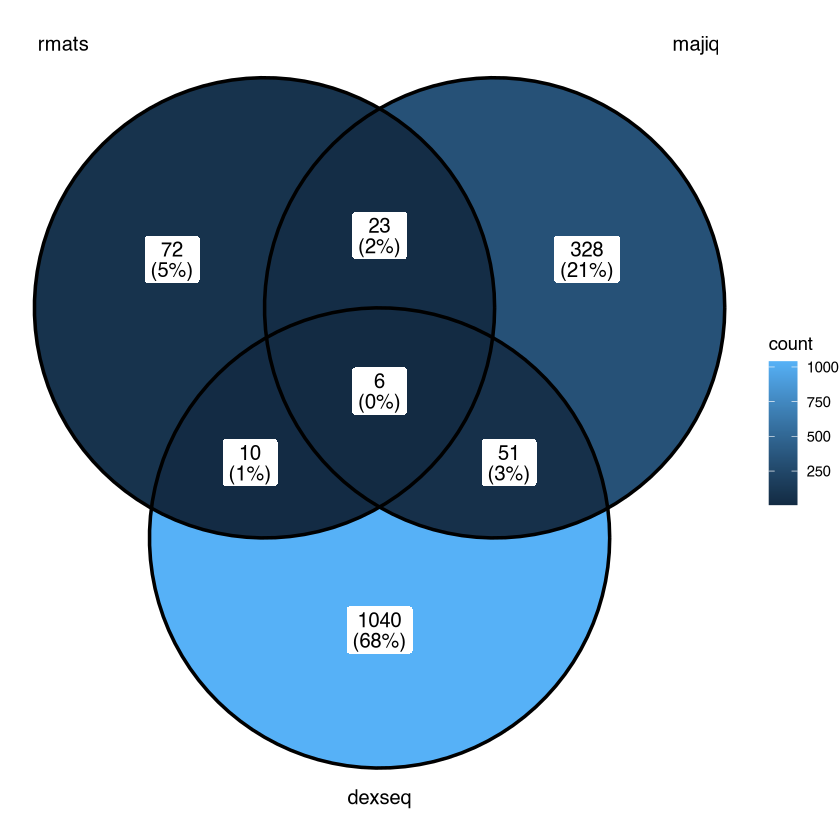

In [38]:
ggVennDiagram(ensembl_gene_ids, label_alpha = 1)

In [3]:
dexseq

groupID,entrezgene_id,featureID,exonBaseMean,dispersion,stat,pvalue,padj,genomicData.seqnames,genomicData.start,⋯,countData.2,countData.3,countData.4,countData.5,countData.6,countData.7,countData.8,countData.9,countData.10,transcripts
<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
ENSMUSG00000000056,67608,E015,1232.13843,0.0004129145,13.36789,2.559690e-04,4.364839e-02,11,121143507,⋯,1280,2243,1020,971,1035,1367,1886,980,996,ENSMUST00000103015
ENSMUSG00000000078,23849,E002,340.18170,0.0017137275,12.02689,5.243858e-04,6.495960e-02,13,5911540,⋯,215,552,365,316,187,371,444,453,429,"ENSMUST00000000080, ENSMUST00000222857"
ENSMUSG00000000149,14673,E001,2215.57997,0.0008512861,11.71801,6.189806e-04,7.052437e-02,5,140744163,⋯,1999,3313,1774,1648,2205,2622,3017,1908,2136,ENSMUST00000000153
ENSMUSG00000000184,12444,E010,77.58359,0.0025043320,35.89450,2.082956e-09,8.018686e-06,6,127125263,⋯,26,96,42,53,96,76,170,94,121,"ENSMUST00000201066, ENSMUST00000201637, ENSMUST00000202363"
ENSMUSG00000000355,68995,E003,109.56666,0.0017889594,11.55386,6.760858e-04,7.397869e-02,X,37690176,⋯,104,182,111,121,65,138,126,105,100,ENSMUST00000134573
ENSMUSG00000000374,216131,E001,882.34554,0.0006278033,14.02260,1.806267e-04,3.604881e-02,10,78022559,⋯,904,1055,730,734,863,1090,1006,809,948,ENSMUST00000000384
ENSMUSG00000000384,21379,E032,46.69778,0.0036531354,11.80795,5.897826e-04,6.897440e-02,11,6575965,⋯,43,43,58,51,38,32,29,50,60,"ENSMUST00000150697, ENSMUST00000156969, ENSMUST00000000394, ENSMUST00000189268, ENSMUST00000131815"
ENSMUSG00000000568,11991,E001,1324.02918,0.0031428761,16.82576,4.097343e-05,1.490438e-02,5,100103794,⋯,1182,1947,1327,1300,1044,1466,1321,1181,1265,ENSMUST00000172361
ENSMUSG00000000600,79264,E044,35.59736,0.0050911056,11.28238,7.824634e-04,8.081574e-02,5,3886778,⋯,26,38,29,25,28,75,56,39,51,"ENSMUST00000080085, ENSMUST00000200386, ENSMUST00000200577, ENSMUST00000199845"
